In [4]:
import results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

sns.set(style = "whitegrid", rc = {
   "legend.frameon": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Lucida Grande",
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.labelsize": 16,
    'legend.fontsize': 12
})
# palette = sns.color_palette(['#EE6123','#0072BB',"#00916E",'#000000' , '#4E148C', '#937860', '#F4D35E', '#F7B05B'])
palette = sns.color_palette(['#0072BB', '#937860', '#4E148C', '#00916E', '#000000', '#EE6123'])

## Combined convergence plot

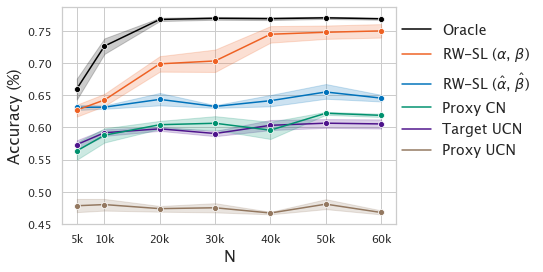

In [82]:
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
oracle_df, _ = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_oracle_R10')

learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)

oracle_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
oracle_df = oracle_df[oracle_df['baseline'].isin(oracle_baselines)]
baselines_df = pd.concat([learn_df, oracle_df])
baselines_df.reset_index(inplace=True)

# baselines_df = baselines_df[baselines_df['alpha_0'] != 0.2]
n_baselines = len(baselines_df['baseline'].unique())


baselines_df = baselines_df[baselines_df['alpha_0'] == 0.4]

fig = sns.lineplot(
    palette=palette[:n_baselines],
    data=baselines_df, x="NS", y="ACC", hue='baseline', ci=68, marker='o')
fig.set_xlabel('N')
fig.set_ylabel('Accuracy (%)')

disp_names = {
    'Target Oracle': 'Oracle',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': 'COM-SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'COM-SL ($\hat{\alpha}$, $\hat{\beta}$)'
}

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 5,0,3,2,1]
plt.legend([handles[idx] for idx in order],[disp_names[labels[idx]] for idx in order],
           bbox_to_anchor=(1.0, .95), loc=2, borderaxespad=0., fontsize='large')

fig.set_xticks([5000, 10000, 20000, 30000, 40000, 50000, 60000], labels=['5k', '10k', '20k', '30k', '40k', '50k', '60k'])
plt.savefig('figs/convergence_plot.png', dpi=500, bbox_inches = "tight")




In [122]:
palette = sns.color_palette(['#EE6123','#0072BB',"#00916E",'#000000' , '#4E148C', '#937860'])
palette

[(0.9333333333333333, 0.3803921568627451, 0.13725490196078433),
 (0.0, 0.4470588235294118, 0.7333333333333333),
 (0.0, 0.5686274509803921, 0.43137254901960786),
 (0.0, 0.0, 0.0),
 (0.3058823529411765, 0.0784313725490196, 0.5490196078431373),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941)]

In [ ]:
oracle_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']

learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)


In [68]:
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL', 'COM-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].unique()


array(['COM-SL', 'RW-SL'], dtype=object)

In [161]:

pd.options.display.float_format = "{:,.2f}".format
learn_df, _  = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_R10')
oracle_df, _ = results.get_erm_convergence_result_df('NENV_erm_convergence_rates_crossfit_oracle_R10')

learn_df.reset_index(inplace=True)
learned_baselines = ['RW-SL', 'COM-SL']
learn_df = learn_df[learn_df['baseline'].isin(learned_baselines)]
learn_df['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
learn_df['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)

oracle_baselines = ['Target Oracle', 'RW-SL', 'COM-SL', 'COM', 'OBS Oracle', 'OBS']
oracle_df = oracle_df[oracle_df['baseline'].isin(oracle_baselines)]
baselines_df = pd.concat([learn_df, oracle_df])
baselines_df.reset_index(inplace=True)

baselines_df['param'] = "(" + baselines_df['alpha_0'].astype(str)+"," +baselines_df['beta_0'].astype(str) + ")"

# Mean dataframe
table_df = baselines_df[baselines_df['NS'] == 60000][['baseline', 'param', 'ACC']].groupby(['baseline', 'param']).mean().reset_index()
mean_df = pd.pivot_table(table_df, values='ACC', index=['baseline'], columns=['param'])
lst = ["OBS", "OBS Oracle", "COM", "COM-SL (learned)", "COM-SL",  "RW-SL (learned)","RW-SL", "Target Oracle"]
mean_df = mean_df.loc[lst]
mean_df = 100*mean_df

# # Se dataframe
table_df =  baselines_df[baselines_df['NS'] == 60000][['baseline', 'param', 'ACC']].groupby(['baseline', 'param']).sem().reset_index()
sem_df = pd.pivot_table(table_df, values='ACC', index=['baseline'], columns=['param'])
lst = ["OBS", "OBS Oracle", "COM", "COM-SL (learned)", "COM-SL",  "RW-SL (learned)","RW-SL", "Target Oracle"]
sem_df = sem_df.loc[lst]
sem_df = 100*sem_df

for col in mean_df:
    mean_df[col] = mean_df[col].apply(lambda x: '{0:.2f}'.format(x))
    sem_df[col] = sem_df[col].apply(lambda x: '{0:.2f}'.format(x))
    mean_df[col] = mean_df[col].astype(str).map(str) + " (\footnotesize {" + sem_df[col].astype(str) + "})"



In [162]:
print(mean_df.to_latex())


\begin{tabular}{llllll}
\toprule
param &                    (0.0,0.4) &                    (0.1,0.3) &                    (0.2,0.2) &                    (0.3,0.1) &                    (0.4,0.0) \\
baseline         &                              &                              &                              &                              &                              \\
\midrule
OBS              &  54.18 (ootnotesize \{0.09\}) &  53.00 (ootnotesize \{0.39\}) &  54.89 (ootnotesize \{1.09\}) &  55.81 (ootnotesize \{0.74\}) &  46.76 (ootnotesize \{0.33\}) \\
OBS Oracle       &  61.57 (ootnotesize \{0.63\}) &  60.95 (ootnotesize \{0.50\}) &  60.49 (ootnotesize \{0.41\}) &  61.00 (ootnotesize \{0.49\}) &  60.54 (ootnotesize \{0.70\}) \\
COM              &  51.36 (ootnotesize \{1.83\}) &  68.24 (ootnotesize \{2.61\}) &  75.05 (ootnotesize \{0.92\}) &  67.77 (ootnotesize \{1.33\}) &  61.88 (ootnotesize \{0.28\}) \\
COM-SL (learned) &  72.38 (ootnotesize \{1.65\}) &  65.45 (oot

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_37473/914019961.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(mean_df.to_latex())


## Experimental study dataset results

In [2]:
def get_ate_result_df(exp_name):
    # NR_erm_ohie_crossfit_oracle_params_R10
    results = []
    for f in glob.glob(f'results/{exp_name}/*TE.csv'):
        results.append(pd.read_csv(f))
    nsdf = pd.concat(results)
    nsdf.drop(columns=['Unnamed: 0'], inplace=True)
    nsdf['param'] = "(" + nsdf['alpha_0'].astype(str)+"," +nsdf['beta_0'].astype(str) + ")"
    nsdf['ate_error'] = nsdf['ate'] - nsdf['ate_hat'] 
    return nsdf

def filter_baselines(df, include_baselines):
    include_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
    df = df[df['baseline'].isin(include_baselines)]
    return df.reset_index()
      

In [47]:
jdf_learned = get_ate_result_df('main_table_jobs_learned').reset_index()

jdf_learned.groupby(['param']).mean()

,index,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,alpha_1_hat,beta_1_hat,NS,...,prw_0.4,pr_0.4,prw_0.45,pr_0.45,prw_0.5,pr_0.5,prw_0.55,pr_0.55,prw_0.6,pr_0.6
param,,,,,,,,,,,,,,,,,,,,,
"(0.0,0.4)",14.5,0.0,0.0,0.4,0.0,0.000378,0.523976,0.258765,0.525457,NaN,...,0.521093,0.221096,0.527561,0.219371,0.529744,0.218082,0.530183,0.218015,0.530063,0.217869
"(0.1,0.3)",14.5,0.1,0.0,0.3,0.0,0.007128,0.428704,0.258398,0.517505,NaN,...,0.544171,0.227670,0.544553,0.226448,0.546084,0.226529,0.545785,0.226194,0.546550,0.226268
"(0.2,0.2)",14.5,0.2,0.0,0.2,0.0,0.051619,0.210870,0.103269,0.577438,NaN,...,0.561011,0.233337,0.559936,0.232288,0.560927,0.232198,0.560672,0.232022,0.560534,0.231892
"(0.3,0.1)",14.5,0.3,0.0,0.1,0.0,0.101995,0.120490,0.058314,0.567620,NaN,...,0.510025,0.210029,0.511297,0.209203,0.511466,0.209114,0.511360,0.209074,0.511458,0.209116
"(0.4,0.0)",14.5,0.4,0.0,0.0,0.0,0.209154,0.044265,0.096423,0.573983,NaN,...,0.525862,0.218270,0.526054,0.218237,0.525842,0.218045,0.526339,0.218205,0.526339,0.218205


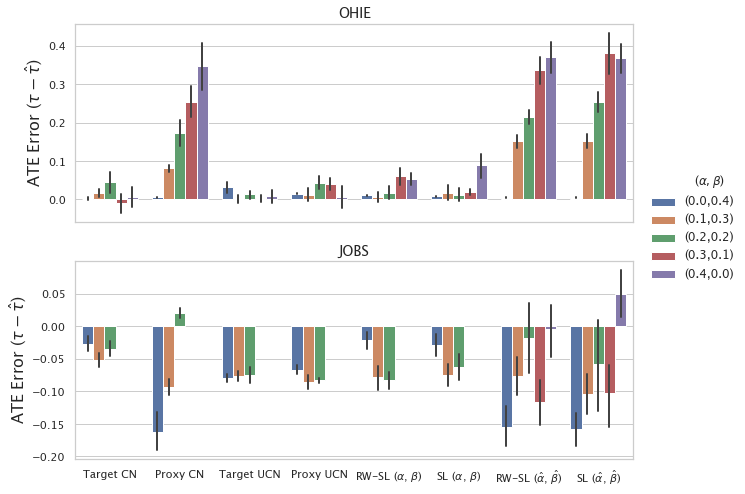

In [350]:
odf_oracle = get_ate_result_df('main_table_ohie_oracle_crossfit').reset_index()
odf_learned = get_ate_result_df('main_table_ohie_learned_crossfit').reset_index()
jdf_oracle = get_ate_result_df('ATE_RERUN_jobs_crossfit_oracle_R10').reset_index()
jdf_learned = get_ate_result_df('main_table_jobs_learned').reset_index()

# Load learned baselines
learned_baselines = ['RW-SL (learned)', 'COM-SL (learned)']
odf_learned['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
odf_learned['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)
odf_learned = odf_learned[odf_learned['baseline'].isin(learned_baselines)]


jdf_learned['baseline'].replace('RW-SL', 'RW-SL (learned)', inplace=True)
jdf_learned['baseline'].replace('COM-SL', 'COM-SL (learned)', inplace=True)
jdf_learned = jdf_learned[jdf_learned['baseline'].isin(learned_baselines)]


# Oracle baselines
include_baselines = ['Target Oracle', 'COM', 'OBS Oracle', 'OBS', 'RW-SL', 'COM-SL']
odf_oracle = odf_oracle[odf_oracle['baseline'].isin(include_baselines)]
jdf_oracle = jdf_oracle[jdf_oracle['baseline'].isin(include_baselines)]

ohie_df = pd.concat([odf_learned, odf_oracle]).sort_values(by=['baseline', 'alpha_0'], ascending=True)
jobs_df = pd.concat([jdf_learned, jdf_oracle]).sort_values(by=['baseline', 'alpha_0'], ascending=True)

disp_names = {
    'Target Oracle': 'Target CN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': r'SL ($\alpha$, $\beta$)',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'COM-SL (learned)' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)',
}


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
g = sns.barplot(data=ohie_df, x='baseline', y='ate_error', hue='param',
                order=include_baselines + learned_baselines, ci=68, errwidth=2, ax=ax1)
ax1.set_xlabel("")
ax1.set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
ax1.set_title('OHIE')
g.legend().set_visible(False)

g = sns.barplot(data=jobs_df, x='baseline',y='ate_error',hue='param',
                ci=68, errwidth=2, ax=ax2, order=include_baselines + learned_baselines)
plt.xlabel("")
ax2.set_ylabel(r'ATE Error ($\tau - \hat{\tau}$)')
ax2.set_title('JOBS')
ax2.legend( title=r"         ($\alpha, \beta$)", bbox_to_anchor=(1.2, 1.5))


# handles, labels = plt.gca().get_legend_handles_labels()
labels = [disp_names[item.get_text()] for item in ax2.get_xticklabels()]
ax2.set_xticklabels(labels)

plt.savefig('figs/tau_bias.png', dpi=500, bbox_inches = "tight")



## Analysis of error parameter estimates

In [211]:

# learn_df = get_ate_result_df('Z_ohie_learned_param_debug')
learn_df = get_ate_result_df('Z_jobs_learned_param_debug')
# learn_df = get_ate_result_df('NATE_erm_ohie_crossfit_learned_R10_00')



learn_df['alpha_0_error'] = learn_df['alpha_0'] - learn_df['alpha_0_hat']
learn_df['beta_0_error'] = learn_df['beta_0'] - learn_df['beta_0_hat']
learn_df['alpha_1_error'] = learn_df['alpha_1'] - learn_df['alpha_1_hat']
learn_df['beta_1_error'] = learn_df['beta_1'] - learn_df['beta_1_hat']

learn_df = learn_df[learn_df['baseline'] == 'RW-SL']
learn_df['param'] = "(" + learn_df['alpha_0'].astype(str)+"," + learn_df['beta_0'].astype(str) + ")"
# learn_df.groupby(['param', 'NS'])['alpha_0_error', 'beta_0_error'].mean()

# sns.barplot(data=learn_df, x="NS", y="alpha_0_error", hue='param', ci=68, marker='o')

In [218]:
learn_df = get_ate_result_df('main_table_jobs_learned')
learn_df

,alpha_0,alpha_1,beta_0,beta_1,alpha_0_hat,beta_0_hat,alpha_1_hat,beta_1_hat,benchmark,NS,...,prw_0.45,pr_0.45,prw_0.5,pr_0.5,prw_0.55,pr_0.55,prw_0.6,pr_0.6,baseline,param
0,0.0,0,0.4,0,0.000549,0.500867,0.109501,0.636878,jobs,NaN,...,0.541918,0.231788,0.538333,0.226667,0.546875,0.230263,0.546875,0.230263,COM-SL,"(0.0,0.4)"
1,0.0,0,0.4,0,0.000549,0.500867,0.109501,0.636878,jobs,NaN,...,0.546875,0.230263,0.546875,0.230263,0.546875,0.230263,0.546875,0.230263,RW,"(0.0,0.4)"
2,0.0,0,0.4,0,0.000549,0.500867,0.109501,0.636878,jobs,NaN,...,0.536290,0.225806,0.546875,0.230263,0.546875,0.230263,0.546875,0.230263,RW-SL,"(0.0,0.4)"
3,0.0,0,0.4,0,0.001421,0.428829,0.036857,0.556469,jobs,NaN,...,0.554167,0.233333,0.562500,0.236842,0.562500,0.236842,0.562500,0.236842,COM-SL,"(0.0,0.4)"
4,0.0,0,0.4,0,0.001421,0.428829,0.036857,0.556469,jobs,NaN,...,0.562500,0.236842,0.562500,0.236842,0.562500,0.236842,0.562500,0.236842,RW,"(0.0,0.4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.4,0,0.0,0,0.113645,0.045714,0.096557,0.542953,jobs,NaN,...,0.545511,0.226667,0.545511,0.226667,0.545511,0.226667,0.545511,0.226667,RW,"(0.4,0.0)"
26,0.4,0,0.0,0,0.113645,0.045714,0.096557,0.542953,jobs,NaN,...,0.545511,0.226667,0.545511,0.226667,0.545511,0.226667,0.545511,0.226667,RW-SL,"(0.4,0.0)"
27,0.4,0,0.0,0,0.251223,0.046016,0.029031,0.609054,jobs,NaN,...,0.534024,0.230769,0.534024,0.230769,0.534024,0.230769,0.534024,0.230769,COM-SL,"(0.4,0.0)"
28,0.4,0,0.0,0,0.251223,0.046016,0.029031,0.609054,jobs,NaN,...,0.534024,0.230769,0.534024,0.230769,0.534024,0.230769,0.534024,0.230769,RW,"(0.4,0.0)"


In [207]:
learn_df['eta_0_min'] = learn_df['alpha_0_hat']
learn_df['eta_0_max'] = 1-learn_df['beta_0_hat']
learn_df['eta_1_min'] = learn_df['alpha_1_hat']
learn_df['eta_1_max'] = 1-learn_df['beta_1_hat']


In [208]:
learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_16218/2504277234.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()


,eta_0_min,eta_0_max,eta_1_min,eta_1_max
param,,,,
"(0.0,0.0)",0.003207,0.949664,0.080949,0.429276
"(0.0,0.4)",0.000755,0.596000,0.095273,0.437051
"(0.1,0.3)",0.012844,0.700105,0.066377,0.454631
"(0.2,0.2)",0.051619,0.789130,0.103269,0.422562
"(0.3,0.1)",0.101995,0.879510,0.058314,0.432380
"(0.4,0.0)",0.209154,0.955735,0.096423,0.426017


In [205]:
# learn_df.groupby(['param'])['alpha_0_hat', 'beta_0_hat', 'alpha_1_hat', 'beta_1_hat'].mean()

# OHIE
learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_16218/492653311.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()


,eta_0_min,eta_0_max,eta_1_min,eta_1_max
param,,,,
"(0.0,0.0)",0.003207,0.949664,0.080949,0.429276
"(0.0,0.4)",0.000755,0.596000,0.095273,0.437051
"(0.1,0.3)",0.012844,0.700105,0.066377,0.454631
"(0.2,0.2)",0.051619,0.789130,0.103269,0.422562
"(0.3,0.1)",0.101995,0.879510,0.058314,0.432380
"(0.4,0.0)",0.209154,0.955735,0.096423,0.426017


In [249]:
alpha = 0.2
beta = 0.3

ci_s = .2
cj_s = .8

ci = (1-beta)*ci_s + alpha*(1-ci_s)
cj = (1-beta)*cj_s + alpha*(1-cj_s)

alpha_hat = (ci_s*cj- ci*cj_s)/(ci_s-cj_s)
beta_hat = (ci*cj_s-ci+ci_s-cj_s+cj-ci_s*cj)/(ci_s-cj_s)


In [250]:
alpha_hat = (ci - (1-beta)*ci_s)/(1-ci_s)
alpha_hat

0.20000000000000007

In [240]:
alpha_hat

0.20000000000000007

In [241]:
beta_hat

0.30000000000000004

<AxesSubplot:xlabel='assumption', ylabel='beta_1_hat'>

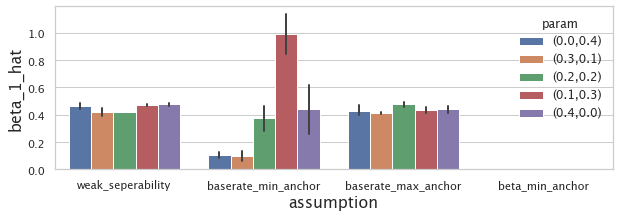

In [277]:
pedf = get_ate_result_df('NATE_jobs_param_assumptions_erm_realworld_learn_params_R10').reset_index()


assumptions = ['weak_seperability', 'baserate_min_anchor', 'baserate_max_anchor','beta_min_anchor']


pedf = pedf[pedf['baseline'] == 'RW-SL']
# pedf = pedf[pedf['assumption'] == 'beta_min_anchor']


plt.figure(figsize=(10,3))
sns.barplot(data=pedf, x='assumption', y='beta_1_hat', hue='param', ci=68, errwidth=2)




In [176]:
# OHIE
learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_16218/2488721978.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['eta_0_min', 'eta_0_max', 'eta_1_min', 'eta_1_max'].mean()


,eta_0_min,eta_0_max,eta_1_min,eta_1_max
param,,,,
"(0.0,0.0)",1.000000e-09,0.002588,1.000000e-09,0.011487
"(0.0,0.4)",1.000000e-09,0.030648,1.000000e-09,0.054081
"(0.1,0.3)",3.574930e-05,0.460925,1.337465e-09,0.071308
"(0.2,0.2)",6.369805e-05,0.562086,1.000000e-09,0.048681
"(0.3,0.1)",5.754529e-04,0.746939,1.000000e-09,0.044414
"(0.4,0.0)",2.831854e-03,0.971088,1.006524e-09,0.062590


In [341]:
def generate_ohie_data(OHIE_PATH, error_params, train_ratio=.7, shuffle=True):
    
    ohie_df = pd.read_csv(OHIE_PATH)
    
    YS = ohie_df[['Y']].squeeze()
    D = ohie_df[['D']].squeeze()
    ohie_df.drop(columns=['Y', 'D'], inplace=True)

    YS_0 = np.zeros_like(YS)
    YS_1 = np.zeros_like(YS)

    YS_0[D==0] = YS[D==0]
    YS_1[D==1] = YS[D==1]

    Y_0 = YS_0.copy()
    Y_1 = YS_1.copy()
    Y = np.zeros_like(YS)
    
    alpha_0_errors = np.random.binomial(1, error_params['alpha_0'], size=ohie_df.shape[0])
    alpha_1_errors = np.random.binomial(1, error_params['alpha_1'], size=ohie_df.shape[0])
    beta_0_errors = np.random.binomial(1, error_params['beta_0'], size=ohie_df.shape[0])
    beta_1_errors = np.random.binomial(1, error_params['beta_1'], size=ohie_df.shape[0])

    Y_0[(Y_0 == 0) & (alpha_0_errors == 1)] = 1
    Y_0[(Y_0 == 1) & (beta_0_errors == 1)] = 0
    Y_1[(Y_1 == 0) & (alpha_1_errors == 1)] = 1
    Y_1[(Y_1 == 1) & (beta_1_errors == 1)] = 0

    Y[D==0] = Y_0[D==0]
    Y[D==1] = Y_1[D==1]

    dataset_y = {
        'YS': YS,
        'YS_0': YS_0,
        'YS_1': YS_1,
        'Y_0': Y_0,
        'Y_1': Y_1,
        'Y': Y,
        'pD': np.ones_like(D) * D.mean(),
        'pD_hat': np.ones_like(D) * D.mean(),
        'D': D,
        'E': np.ones_like(YS) # Include for computing the ATT on JOBS test data
    }

    X, Y = pd.DataFrame(ohie_df), pd.DataFrame(dataset_y)

    print(Y['YS'].mean())

    if shuffle: 
        suffle_ix = permutation(X.index)
        X = X.iloc[suffle_ix]
        Y = Y.iloc[suffle_ix]

    split_ix = int(X.shape[0]*train_ratio)
    X_train = X[:split_ix]
    X_test = X[split_ix:]
    Y_train = Y[:split_ix]
    Y_test = Y[split_ix:]

    #Selection bias: medicare opportunity not provided to individuals above the federal poverty line
    X_train_s = X_train[(Y_train['D'].to_numpy() == 0) |
        ((Y_train['D'].to_numpy() == 1) & (X_train['above_federal_pov'].to_numpy() == 0))]

    Y_train_s = Y_train[(Y_train['D'] == 0).to_numpy() | 
        ((Y_train['D'] == 1).to_numpy() & (X_train['above_federal_pov'] == 0).to_numpy())]  


    X_train_s = (X_train_s - X_train_s.mean(axis=0))/X_train_s.std(axis=0)
    X_test = (X_test - X_train_s.mean(axis=0))/X_train_s.std(axis=0)

    print(Y_train_s['YS'].mean())
    print(Y_test['YS'].mean())

    return X_train_s, X_test, Y_train_s, Y_test

In [347]:
from attrdict import AttrDict
import numpy as np
import pandas as pd
from numpy.random import permutation
from data import loaders

error_params = AttrDict({
    'alpha_0': 0.0,
    'alpha_1': 0.0,
    'beta_0': 0.0,
    'beta_1': 0.0,
})

X_train_s, X_test, Y_train_s, Y_test = generate_ohie_data("data/OHIE/ohie_data.csv",
                                                          error_params, train_ratio=.7, shuffle=True)



0.09512082499615207
0.0873523622047244
0.10002564760194922


In [348]:
Y_train_s.mean()

YS        0.087352
YS_0      0.050443
YS_1      0.036909
Y_0       0.050443
Y_1       0.036909
Y         0.087352
pD        0.476297
pD_hat    0.476297
D         0.413632
E         1.000000
dtype: float64

In [330]:
Y_test.mean()

YS        0.096435
YS_0      0.046679
YS_1      0.049756
Y_0       0.000000
Y_1       0.000000
Y         0.000000
pD        0.476297
pD_hat    0.476297
D         0.471403
E         1.000000
dtype: float64

In [325]:
Y_train_s.mean()

YS        0.093788
YS_0      0.044200
YS_1      0.049588
Y_0       0.199230
Y_1       0.000000
Y         0.103463
pD        0.476297
pD_hat    0.476297
D         0.476855
E         1.000000
dtype: float64

In [308]:
Y_test['YS'].mean()

0.09156193895870736

In [314]:
Y_train_s[Y_train_s['D'] == 1]['YS_1'].mean()



0.10688781386777241

In [301]:
Y_test['Y'].mean()

0.0

In [120]:
learn_df['alpha_1_hat'].mean()

0.0

In [121]:
learn_df['beta_1_hat'].mean()

0.0

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_16218/2806566320.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['alpha_0_error', 'beta_0_error', 'alpha_1_error', 'beta_1_error'].mean()


KeyError: "Columns not found: 'beta_1_error', 'alpha_1_error'"

/var/folders/w_/rwxvw5hn1ng2qvm6353gkvqw0000gr/T/ipykernel_16218/2906170567.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  learn_df.groupby(['param'])['alpha_0_error', 'beta_0_error'].mean()


,alpha_0_error,beta_0_error
param,,
"(0.0,0.4)",-1.000000e-09,-0.569352
"(0.1,0.3)",9.996425e-02,-0.239075
"(0.2,0.2)",1.999363e-01,-0.237914
"(0.3,0.1)",2.994245e-01,-0.153061
"(0.4,0.0)",3.971681e-01,-0.028912


## Gamma plot  

In [11]:
jobs_df = get_ate_result_df('main_table_jobs_oracle')

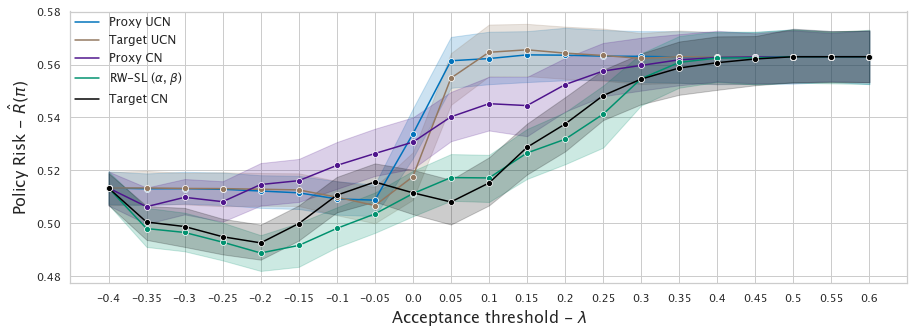

In [9]:
jobs_df = get_ate_result_df('main_table_jobs_oracle')
jobs_df.rename(columns={'pr_-4':'pr_-.4'}, inplace=True)
pg_baselines = ['Target Oracle', 'RW-SL', 'COM', 'OBS Oracle', 'OBS']
gamma_settings = [i for i in jobs_df if 'pr_' in i][1:]
disp_gamma = gamma_settings[::2]
# gamma_settings[0] = 'pr_-.4'
# jobs_df = jobs_df[jobs_df['alpha_0'] != .2]


pr_results = ['baseline'] + gamma_settings
disp_names = {
    'Target Oracle': 'Target CN',
    'RW-SL': r'RW-SL ($\alpha$, $\beta$)',
    'COM': 'Proxy CN',
    'COM-SL': 'COM-SL',
    'RW': 'RW',
    'Proxy Oracle': r'$f_{Y_t}$',
    'OBS Oracle': 'Target UCN',
    'OBS': 'Proxy UCN',
    'RW-SL (learned)' : r'RW-SL ($\hat{\alpha}$, $\hat{\beta}$)',
    'SL' : r'SL ($\hat{\alpha}$, $\hat{\beta}$)'
}

gammadf = jobs_df[pr_results].melt(id_vars=['baseline'], var_name="gamma", value_name='policy_risk')
gammadf = gammadf[gammadf['baseline'].isin(pg_baselines)]


plt.figure(figsize=(15,5))
fig = sns.lineplot(data=gammadf, x='gamma', hue='baseline', y='policy_risk',
                   marker='o', ci=68, palette=palette[:len(pg_baselines)])


plt.xlabel('Acceptance threshold - $\lambda$')
plt.ylabel('Policy Risk - $\hat{R}(\pi)$')
fig.set_xticks([i for i in range(len(gamma_settings))], labels=[float(i.split('_')[1]) for i in gamma_settings])

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([h for h in handles],[disp_names[label] for label in labels], loc='best', borderaxespad=0., fontsize='medium')

# JOBS data

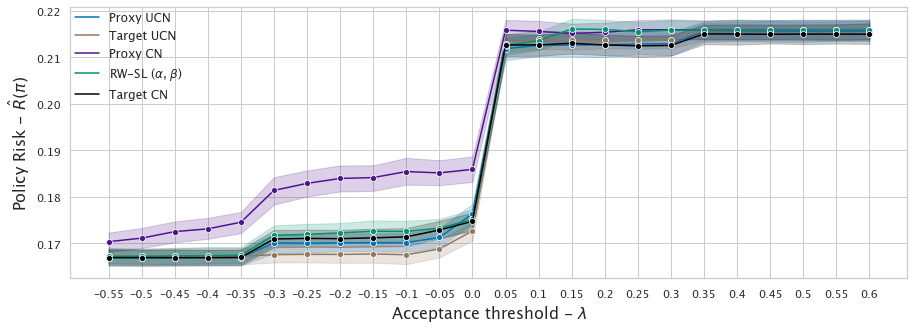

In [36]:
#OHIE plot

## Plots with 

In [7]:
def plot_experimental_data_results(df, metric):
    plt.figure(figsize=(12, 6))
    g = sns.barplot(data=df, x='baseline', y=metric, hue='param', ci=68, errwidth=2)
    plt.xlabel("")
    
    ylabel = "MSE ATE" if metric == "ate_error" else "Policy Risk"
    
    plt.ylabel(ylabel)
    plt.legend( title=r"         ($\alpha, \beta$)")
#     models = ['X -> Y', 'X,T->Y (RW-SL)', 'X->$Y_t$* (Target Oracle)','X->Y*', 'X,T->Y', 'X,T->Y (SL)', 'X,T->Y (RW)', 'X->$Y_t$ (Proxy Oracle)']
#     g.set_xticks(range(len(models)), models, size=12)
#     plt.xticks(rotation=45)


plot_experimental_data_results(ohie, 'ate_error')

NameError: name 'ohie' is not defined

In [35]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data=jobs, x='baseline', y="pr_0.2", ci=68, errwidth=2, capsize=.05)

plt.ylabel("Policy risk")


NameError: name 'jobs' is not defined

<Figure size 864x432 with 0 Axes>

In [71]:
# results/main_table_ohie_learned_crossfit

learn = pd.read_csv('results/main_table_jobs_learned/runs=10_epochs=20_alpha=0.4_beta=0.0_TE.csv')



In [74]:
learn[['alpha_0','alpha_0_hat','beta_0','beta_0_hat','alpha_1','alpha_1_hat','beta_1','beta_1_hat']]

,alpha_0,alpha_0_hat,beta_0,beta_0_hat,alpha_1,alpha_1_hat,beta_1,beta_1_hat
0,0.4,0.212896,0.0,0.015439,0,0.054855,0,0.606340
1,0.4,0.212896,0.0,0.015439,0,0.054855,0,0.606340
2,0.4,0.212896,0.0,0.015439,0,0.054855,0,0.606340
3,0.4,0.281029,0.0,0.037167,0,0.305402,0,0.518423
4,0.4,0.281029,0.0,0.037167,0,0.305402,0,0.518423
5,0.4,0.281029,0.0,0.037167,0,0.305402,0,0.518423
6,0.4,0.255162,0.0,0.085431,0,0.209944,0,0.545950
7,0.4,0.255162,0.0,0.085431,0,0.209944,0,0.545950
8,0.4,0.255162,0.0,0.085431,0,0.209944,0,0.545950
9,0.4,0.193129,0.0,0.050098,0,0.053716,0,0.605259
